# Lab 7 - Performance Metrics for Classification Problems

## Goal: Evaluating a model for MNIST classification.

## Introduction

__Classifier:__ An algorithm can be said to be a classifier, if it solves a classification problem.

__Classification__: It refers to the problem of, identifying to which category an observation belongs.

|                 |        |
|-------------------------|------------------|
| Logistic Regression     | Decision Trees   |
| Random Forests          | SVM              |
| KNN                     | Naive Bayes      |

Importing the required libraries for this notebook.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tabulate import tabulate

from scipy.stats import skew
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

### Obtaining the Dataset


In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

- __mnist_784__: The dataset contains 70,000 images of handwritten digits.

- **784**: Each image is represented by 28x28 pixel image flattened into a 1D array of 784 elements.

- __as_frame__: Choosing this as false, does not convert the dataset into a pandas dataframe.

- __parser__: Setting this to auto, allows scikit-learn automatically selects the appropriate parser to load the dataset from OpenML

In [3]:
# URL -> This leads towards the MNIST dataset on OpenML.
print(mnist.url)
print(mnist.DESCR)

https://www.openml.org/d/554
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images wer

### Insights from the description:

- The MNIST dataset is a collection of handwritten numbers, neatly organized into 28x28 pixel images. This makes it perfect for teaching computers to recognize digits without much fuss.

- Researchers found an interesting trick to improve computer accuracy with this dataset. By adjusting how the numbers are positioned in the images, they could significantly boost the computer's ability to recognize them.

- To ensure fair learning, the dataset creators carefully balanced the handwriting samples from different groups, like government workers and high school students. This prevents the computer from favoring one style of handwriting over another.

In [4]:
# This represents the number of rows/instances and the columns/features in the dataset
print(mnist.data.shape)

(70000, 784)


From the description we can analyze that:
- 70,000 represents the number of images
- 784 represents each pixel feature for each image.

In [5]:
X = mnist.data
y = mnist.target

Target represents the actual number of which we have the image in the specific row.
For example: 
- __Target:__ We have `5` in the first row which is the target.
- __Data:__ We have `784` values for each pixel in the `28x28` size image.

## Exploratory Data Analysis (EDA)

Reference: [EDA for Image Classification (Medium)](https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a)

In [6]:
def plot_digit_img(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

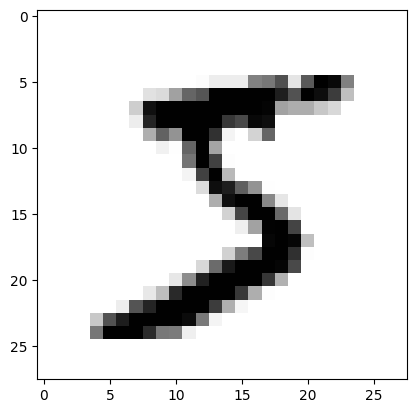

In [7]:
plot_digit_img(X[0])
plt.show()


We can see that the first image is the digit `5`. It is following the greyscale, where each value represents the intensity of light or darkness of the pixel, with 0 being white and 255 being black.

### Getting the First 10 Digits in the Dataset

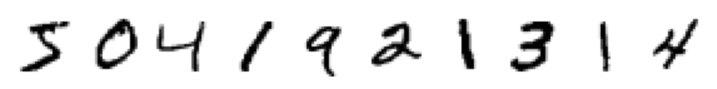

In [8]:
# First 10 images in the dataset.
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:10]):
    plt.subplot(10, 10, idx + 1)
    plot_digit_img(image_data)
    plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Histogram

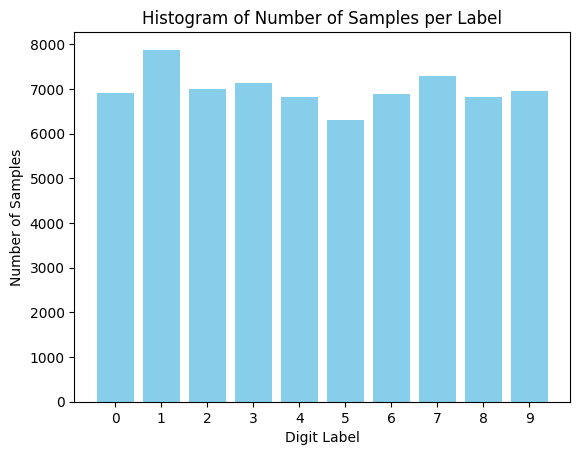

In [9]:
label_counts = np.bincount(y.astype(int))

# Plot histogram
plt.bar(range(10), label_counts, color='skyblue')
plt.xlabel('Digit Label')
plt.ylabel('Number of Samples')
plt.title('Histogram of Number of Samples per Label')
plt.xticks(range(10))
plt.show()

### Histogram Analysis:

- The histogram displays the distribution of samples per digit label from 0 to 9.
- Each bar represents a digit label, and its height indicates the count of samples available for that label. 

- **Uniform Distribution:**
  All bars in the histogram are nearly equal in height, indicating a relatively uniform distribution of samples across all digit labels.

  | |            Label     |    Count    |
  |---|-------------------------|------------------|
  |Highest| 1     | 7877   |
  |Lowest| 5          | 6313              |


-----
## Skewness

### For Each Digit: 

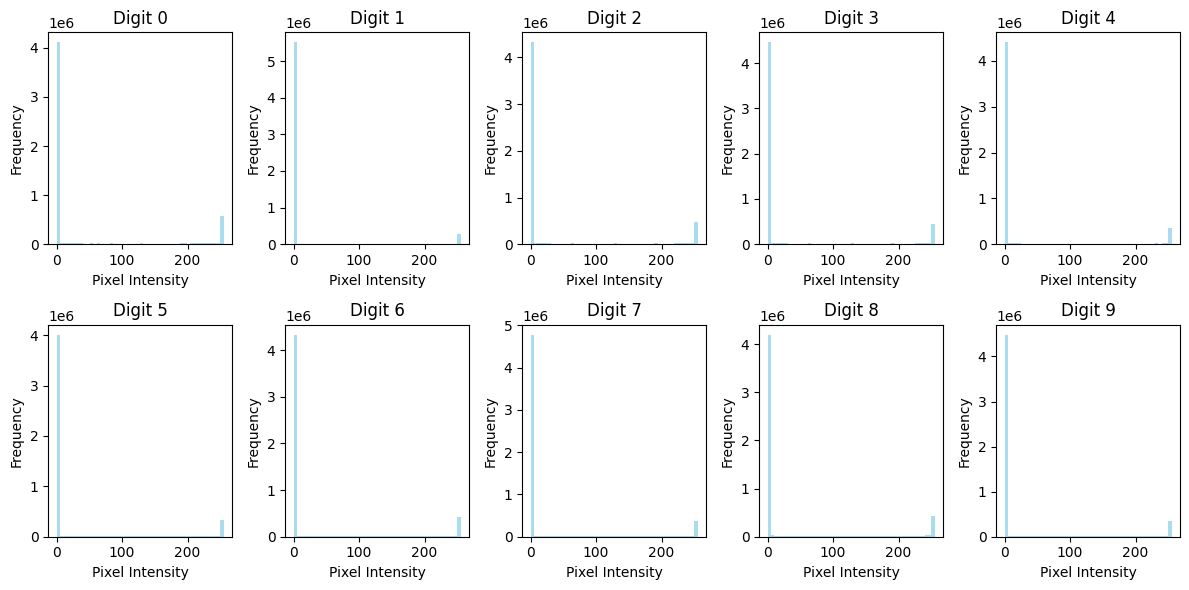

In [10]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.hist(X[y == str(i)].flatten(), bins=50, color='skyblue', alpha=0.7)
    plt.title(f"Digit {i}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### For Overall Dataset:

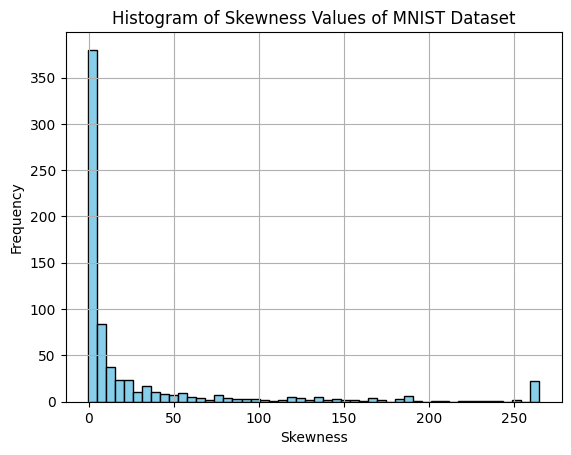

In [11]:
skewness = skew(X, axis=0)

plt.hist(skewness, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.title('Histogram of Skewness Values of MNIST Dataset')
plt.grid(True)
plt.show()

### Skewness: 
- It measures how much a dataset's distribution is asymmetrical. If a distribution is skewed to the left, it means there are more data points on the right side of the center, and vice versa for right skewness.

- The given graph showcases a left-skewed distribution, where the tail extends towards the lower end.

From the graph of Pixel Intensities and Skewness we can analyze that all the pixel values lie between 0 and 255.

- Lots of Light Pixels: Most of the pixels in the images are lighter, closer to white or very light gray, with values mainly between 0 and 25.

- Not Many Dark Pixels: There aren't many pixels that are dark, closer to black, with only a few scattered beyond 50.
Black pixels are relatively high when compared to darker shades of gray.

- Matches Handwriting: This matches what you'd expect for handwritten numbers, where the background is light and the numbers are darker.


----
### Check for Variability in Image sizes

In [12]:
# Count unique image dimensions
image_shapes = [tuple(image.shape) for image in X]
shape_counts = Counter(image_shapes)

# Print unique shapes and their frequencies
print("Unique Image Shapes and Their Frequencies:")
for shape, count in shape_counts.items():
    print(f"Shape: {shape}, Count: {count}")


Unique Image Shapes and Their Frequencies:
Shape: (784,), Count: 70000


We can analyze that there is a consistency with image sizes throughout the dataset.

---
## Checking for Variability Among each Digit

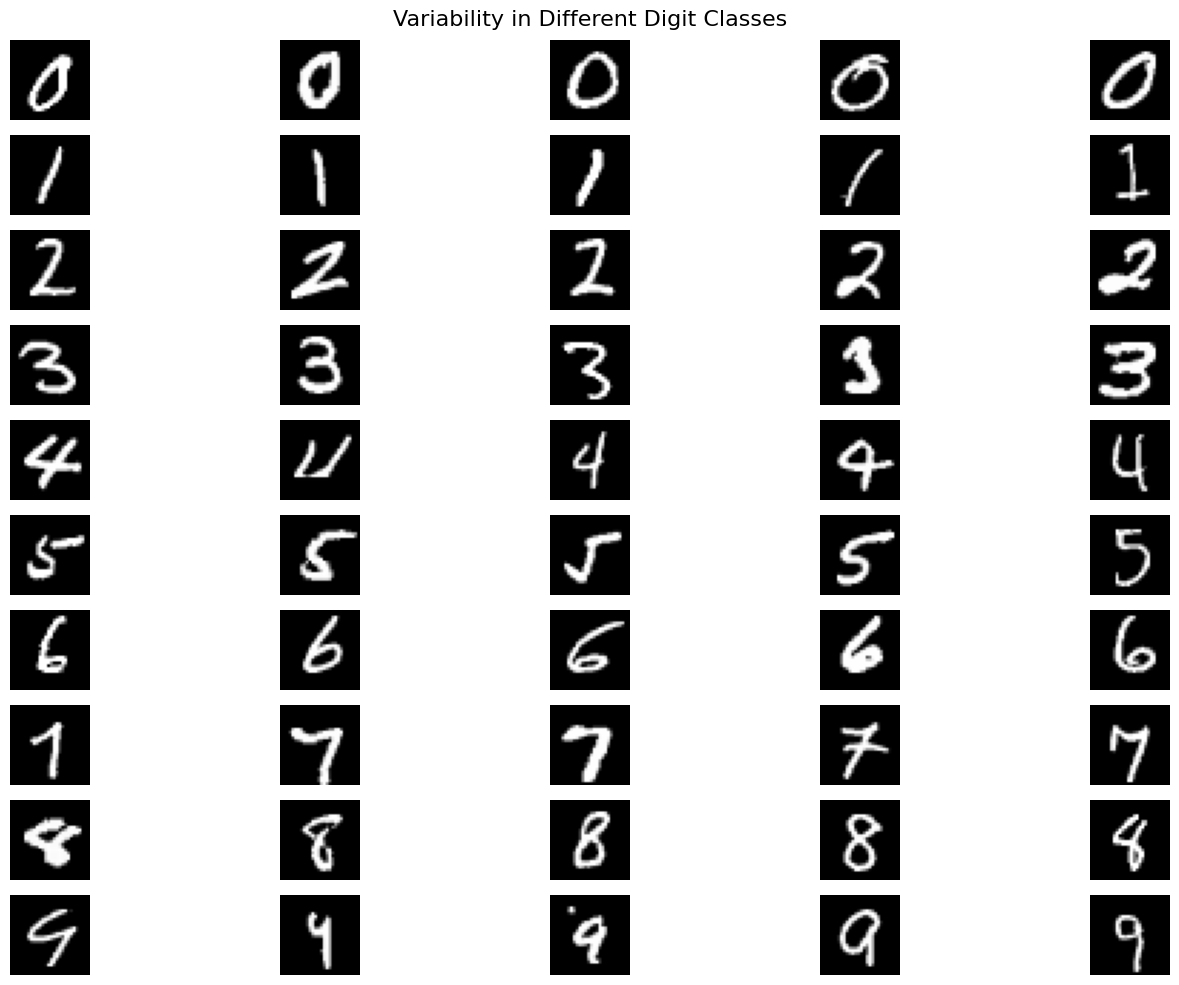

In [13]:
# Define the number of instances to display for each digit class
num_instances_per_class = 5

# Plot images for each digit class
num_classes = 10
plt.figure(figsize=(15, 10))
for digit_to_visualize in range(num_classes):
    # Select random images of the specified digit
    digit_indices = np.where(y == str(digit_to_visualize))[0]
    random_indices = np.random.choice(digit_indices, size=num_instances_per_class, replace=False)
    
    # Plot images for the current digit class
    for i, image_idx in enumerate(random_indices):
        image = X[image_idx].reshape(28, 28)
        plt.subplot(num_classes, num_instances_per_class, digit_to_visualize * num_instances_per_class + i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

plt.suptitle("Variability in Different Digit Classes", fontsize=16)
plt.tight_layout()
plt.show()

We can see that human's write each digit in a different approach, making the dataset have variability for each digit, even when the digits are considered as a whole.

----
## Standard Deviation Image

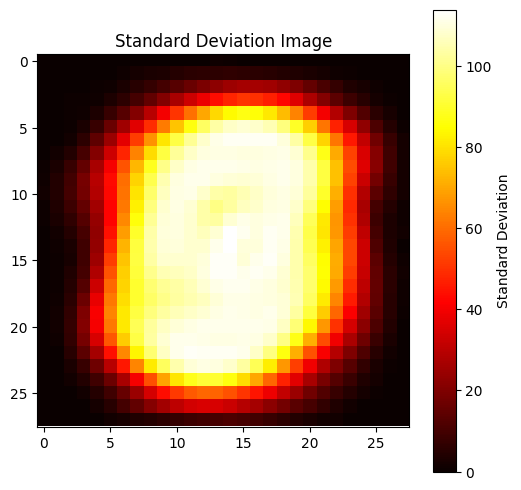

In [14]:
# Calculate the standard deviation image
std_image = np.std(X, axis=0).reshape(28, 28)

# Plot the standard deviation image
plt.figure(figsize=(6, 6))
plt.imshow(std_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Standard Deviation')
plt.title('Standard Deviation Image')

plt.show()

The provided image resembles a Standard Deviation Image, represented as a heat map.

__Key points:__

- Colors ranging from dark red to yellow signify varying standard deviation levels.
- Center of the image is lighter (yellow), indicating higher standard deviation.
- Moving outward, colors darken (red), indicating lower standard deviation.


- The extreme corners of the image are not used more, when compared to the middle.
- This indicates that majority of the digits are towards the middle of the image.

---- 
## Choosing 4 Classes from the Dataset: [1, 4, 7, 9]

We can see that (1,7) and (4,9) when written as digits have similar structure, we can assume that we might see similarities in the prediction levels, and various scores which are to be calculated.

In [15]:
# Define selected classes
selected_classes = [1, 4, 7, 9]

# Filter dataset for selected classes
X_selected = X[np.isin(y.astype(int), selected_classes)]
y_selected = y[np.isin(y.astype(int), selected_classes)]

# Check alignment
if len(X_selected) == len(y_selected):
    print("Data and target labels are still aligned.")
else:
    print("Data and target labels are NOT aligned.")

Data and target labels are still aligned.


validating that the target object and the data (features) object are still aligned if the number of classes is reduced.

----

## Evaluation on Validation Dataset Using SGDClassifier from [Kaggle](https://www.kaggle.com/code/alanperfettini/mnist-classifying-cheatsheet)

### Splitting the Dataset into Train, Validation and Test

In [16]:
# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the classifier
sgd_clf = SGDClassifier(random_state=42)

# Initialize lists to store metrics for each class
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []
accuracy_scores = []

In [17]:
# Calculate metrics for each class
for cls in selected_classes:
    # Convert labels to binary (True for the current class, False for other classes)
    y_train_binary = (y_train == str(cls))
    y_val_binary = (y_val == str(cls))
    
    # Train the classifier
    sgd_clf.fit(X_train, y_train_binary)
    
    # Make predictions on the validation set
    preds_val = sgd_clf.predict(X_val)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_val_binary, preds_val)
    confusion_matrices.append(cm)

    accuracy = accuracy_score(y_val_binary, preds_val)
    accuracy_scores.append(accuracy)
    
    # Calculate precision, recall, and f1-score
    precision_scores.append(precision_score(y_val_binary, preds_val))
    recall_scores.append(recall_score(y_val_binary, preds_val))
    f1_scores.append(f1_score(y_val_binary, preds_val))


----
### Confusion Matrix:


- A confusion matrix allows us to see how well the system is doing at classifying things correctly.
- It shows us:
    - When it gets things right (true positives and true negatives)
    - When it makes mistakes (false positives and false negatives). 
- By which, we can tell how accurate the system is.

In [18]:
# Print confusion matrices as a table with additional metrics
print("\nConfusion Matrices:")
for i, cls in enumerate(selected_classes):
    matrix = confusion_matrices[i]
    true_negatives = matrix[0, 0]
    false_positives = matrix[0, 1]
    false_negatives = matrix[1, 0]
    true_positives = matrix[1, 1]
    
    headers = [f"Predicted {cls}", f"Predicted Rest", "Total"]
    table_data = [
        [f"Actual {cls}", true_positives, false_positives, true_positives + false_positives],
        ["Actual Rest", false_negatives, true_negatives, false_negatives + true_negatives],
        ["Total", true_positives + false_negatives, false_positives + true_negatives, np.sum(matrix)]
    ]
    
    table = tabulate(table_data, headers, tablefmt="grid")
    print(f"\nClass {cls} vs Rest:")
    print(table)



Confusion Matrices:

Class 1 vs Rest:
+-------------+---------------+------------------+---------+
|             |   Predicted 1 |   Predicted Rest |   Total |
+=============+===============+==================+=========+
| Actual 1    |          1129 |                7 |    1136 |
+-------------+---------------+------------------+---------+
| Actual Rest |            17 |             3190 |    3207 |
+-------------+---------------+------------------+---------+
| Total       |          1146 |             3197 |    4343 |
+-------------+---------------+------------------+---------+

Class 4 vs Rest:
+-------------+---------------+------------------+---------+
|             |   Predicted 4 |   Predicted Rest |   Total |
+=============+===============+==================+=========+
| Actual 4    |           973 |               41 |    1014 |
+-------------+---------------+------------------+---------+
| Actual Rest |            80 |             3249 |    3329 |
+-------------+-------------

### Confusion Matrix:

1. **Class 1, 4, and 7 Classification:**
   - These classes exhibit high true positive rates, indicating successful identification by the classifier.
   - False positive rates are generally low or moderate, suggesting good precision in predicting these classes.

2. **Effective Discrimination from Rest:**
   - The classifier demonstrates strong ability to distinguish Class 1, 4, and 7 from the rest of the classes, as indicated by high true negative rates.

3. **Decent Performance for Class 9:**
   - While Class 9 shows slightly lower true positive rates compared to other classes, the classifier maintains reasonable accuracy with moderate false positive rates.

4. **Overall Classifier Reliability:**
   - The classifier's performance across multiple classes suggests robustness and effectiveness in classification tasks.
   - These insights indicate the classifier's capability to accurately identify specific classes while maintaining a low rate of misclassifications.


----
### Accuracy, Precision, Recall, F1:

__Precision__: Measures how accurately the model predicts positives, emphasizing correct identifications over missed ones.

__Recall__: Focuses on the model's ability to capture all positives, highlighting its capacity to avoid missing instances, even if it means more false positives.

__F1 Score__: It's a metric that balances precision and recall, offering a unified measure of a model's performance.

__Accuracy__: It measures the proportion of correctly classified instances out of the total instances.

In [19]:
# Define table data
table_data = [["Class", "Precision", "Recall", "F1 Score", "Accuracy"]]
for i, cls in enumerate(selected_classes):
    table_data.append([cls, precision_scores[i], recall_scores[i], f1_scores[i], accuracy_scores[i]])

# Print the table
print("\nMetrics Table:")
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


Metrics Table:
+---------+-------------+----------+------------+------------+
|   Class |   Precision |   Recall |   F1 Score |   Accuracy |
+=========+=============+==========+============+============+
|       1 |    0.993838 | 0.985166 |   0.989483 |   0.994474 |
+---------+-------------+----------+------------+------------+
|       4 |    0.959566 | 0.924027 |   0.941461 |   0.972139 |
+---------+-------------+----------+------------+------------+
|       7 |    0.952558 | 0.941176 |   0.946833 |   0.973521 |
+---------+-------------+----------+------------+------------+
|       9 |    0.831384 | 0.807765 |   0.819404 |   0.913424 |
+---------+-------------+----------+------------+------------+


The metrics table summarizes performance measures for different classes.

__Key findings:__

- Class 1 and Class 9, precision, recall, and F1 Score are notably high, suggesting effective classification.

- Class 4 and Class 7 exhibit similar performance metrics, indicating consistent but slightly lower effectiveness comparitively. 

----
## Precision-Recall Curve

It plots the trade-off between precision and recall, helping to assess model performance across various classification thresholds.

In [20]:
# Define selected class
chosen_class = 9

# Filter dataset for the chosen class vs. all others
X_binary = X.copy()
y_binary = (y == str(chosen_class)).astype(int)

# Split the dataset into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_binary, y_binary, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the classifier
sgd_clf = SGDClassifier(random_state=42)

# Train the classifier
sgd_clf.fit(X_train, y_train)

# Get decision scores for positive class (chosen class)
y_scores = sgd_clf.decision_function(X_val)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

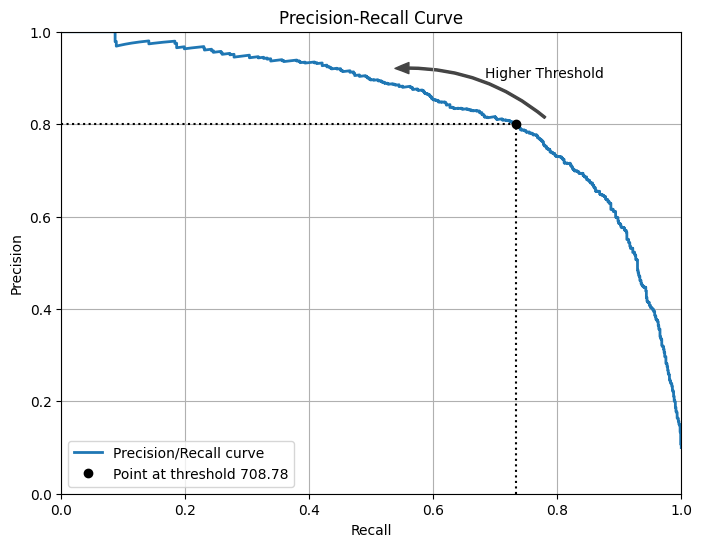

In [21]:
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label="Precision/Recall curve")

# Add annotation for a specific threshold
threshold_idx = np.argmax(precision >= 0.8)  # Choose threshold where precision is at least 0.8
plt.plot([recall[threshold_idx], recall[threshold_idx]], [0., precision[threshold_idx]], "k:")
plt.plot([0.0, recall[threshold_idx]], [precision[threshold_idx], precision[threshold_idx]], "k:")
plt.plot([recall[threshold_idx]], [precision[threshold_idx]], "ko", label=f"Point at threshold {thresholds[threshold_idx]:.2f}")

plt.gca().add_patch(
    patches.FancyArrowPatch(
        (recall[threshold_idx] +0.05, precision[threshold_idx] + 0.01), 
        (recall[threshold_idx]-0.2, precision[threshold_idx] + 0.12),
        connectionstyle="arc3,rad=.2",
        arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444"
    )
)

plt.text(recall[threshold_idx] - 0.05, precision[threshold_idx] + 0.1, "Higher Threshold", color="black")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()


## __Insights:__

The above graph is of a Precision-Recall Curve, which assesses classifier quality based on precision and recall.

__Key Points:__
- Precision: Accuracy of positive predictions.
- Recall: Accuracy of identifying actual positives.

__Observations:__

- The curve's shape shows the trade-off between precision and recall
- With higher area under the curve indicating better performance.
- The marked point on the curve has a threshold of 708.78.

__Conclusion:__

- If we keep increasing the threshold value beyond 708.78, our precision goes up but at the expense of recall.
- Similarly, when the threshold decreases, the recall goes up but the precision becomes worse.

-----
## Increase Precision/Accuracy on Validation/Test Dataset

In [22]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd

def calculate_metrics(y_true, y_scores):
    thresholds = sorted(y_scores, reverse=True)
    results = []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        results.append([threshold, precision, recall])

    df_results = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall'])
    return df_results

def find_best_threshold(df_results):
    best_precision_row = df_results[df_results['Precision'] == df_results['Precision'].max()]
    best_recall_row = df_results[df_results['Recall'] == df_results['Recall'].max()]

    best_precision_threshold = best_precision_row['Threshold'].values[0]
    best_recall_threshold = best_recall_row['Threshold'].values[0]

    return best_precision_threshold, best_recall_threshold

def apply_threshold_and_get_scores(y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    return y_pred

def calculate_final_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return precision, recall

### Validation Dataset

In [23]:
# For validation dataset
y_scores_val = sgd_clf.decision_function(X_val)

df_results_val = calculate_metrics(y_val, y_scores_val)
best_precision_threshold_val, best_recall_threshold_val = find_best_threshold(df_results_val)

y_pred_val_at_best_precision = apply_threshold_and_get_scores(y_scores_val, best_precision_threshold_val)
y_pred_val_at_best_recall = apply_threshold_and_get_scores(y_scores_val, best_recall_threshold_val)

precision_val_precision, recall_val_precision = calculate_final_metrics(y_val, y_pred_val_at_best_precision)
precision_val_recall, recall_val_recall = calculate_final_metrics(y_val, y_pred_val_at_best_recall)

validation_results = pd.DataFrame({
    'Metric': ['Precision', 'Recall'],
    'Chosen Threshold': [best_precision_threshold_val, best_recall_threshold_val],
    'Best Precision': [precision_val_precision, recall_val_precision],
    'Best Recall': [precision_val_recall, recall_val_recall]
    
})

print("\nValidation set results:")
validation_results


Validation set results:


,Metric,Chosen Threshold,Best Precision,Best Recall
0,Precision,6784.973365,1.000000,0.107103
1,Recall,-21853.171887,0.000954,1.000000


From the validation set, it is evident that the maximum attainable threshold is 1 for both recall and precision.

- In order to achieve a precision of 100%, we notice that the recall drops to 10% when the chosen threshold is 6784.97.

- Conversely, aiming for a recall of 100% results in a precision decrease to 0.09% when the chosen threshold is -21853.17.


### Test Dataset

In [24]:
# For test dataset
y_scores_test = sgd_clf.decision_function(X_test)

df_results_test = calculate_metrics(y_test, y_scores_test)
best_precision_threshold_test, best_recall_threshold_test = find_best_threshold(df_results_test)

y_pred_test_at_best_precision = apply_threshold_and_get_scores(y_scores_test, best_precision_threshold_test)
y_pred_test_at_best_recall = apply_threshold_and_get_scores(y_scores_test, best_recall_threshold_test)

precision_test_precision, recall_test_precision = calculate_final_metrics(y_test, y_pred_test_at_best_precision)
precision_test_recall, recall_test_recall = calculate_final_metrics(y_test, y_pred_test_at_best_recall)

test_results = pd.DataFrame({
    'Metric': ['Precision', 'Recall'],
    'Chosen Threshold': [best_precision_threshold_test, best_recall_threshold_test],
    'Best Precision': [precision_test_precision, recall_test_precision],
    'Best Recall': [precision_test_recall, recall_test_recall],
    
})

print("\nTest set results:")
test_results



Test set results:


,Metric,Chosen Threshold,Best Precision,Best Recall
0,Precision,9433.054784,1.00000,0.103179
1,Recall,-25509.181571,0.00096,1.000000


From the test set, we can observe that the max achievable treshold is 1 for both recall and precision.

- To achieve Precision of 100%, we see that the recall falls down to 10%, when the chosen threshold is 9433.05

- When desired recall is 100%, we see that the precision falls down to 0.09% when the chosen threshold is -25509.18

This is what was depicted in the graph, As the threshold value decreases, the recall increse which can be clearly noticed with the help of threshold value.

----
## **Conclusion:**

1. **Dataset Overview**: MNIST dataset contains 70,000 handwritten digit images, each 28x28 pixels.

2. **Data Exploration**:
   - Uniform distribution of samples across digit labels.
   - Skewness analysis reveals pixel intensity distribution.
   - Standard deviation image highlights variations in pixel intensities.

3. **Model Evaluation**:
   - SGDClassifier performs well on a subset of four classes (1, 4, 7, and 9).
   

4. **Analysis**:
   - Confusion matrices show effective classification across selected classes.
   - Precision-recall curve illustrates trade-offs for one chosen class (Class 9).
   - Threshold optimization enhances precision or recall without retraining.

5. **Optimization Insights**:
   - Model demonstrates robust performance with high precision and recall rates.
   - Threshold adjustments offer fine-tuning options for specific requirements.
   
6. **Overall Conclusion**:
   - Analysis provides a practical framework for classification tasks on MNIST.
